In [ ]:
from scipy.stats import t, jarque_bera
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# define directories
base_dir = os.getcwd()

# load data
df = pd.read_excel(os.path.join(base_dir, "Problem_Set1.xlsx"),
                   index_col="date",
                   skiprows=5)
df.index = pd.to_datetime(df.index, format="%Y%m")

df = df.rename(columns={"Market (Value Weighted Index)": "Market"})

            5         10        25        50
mean  1.516418  1.232630  1.211875  1.210693
std   9.867100  6.811804  5.577089  5.428105


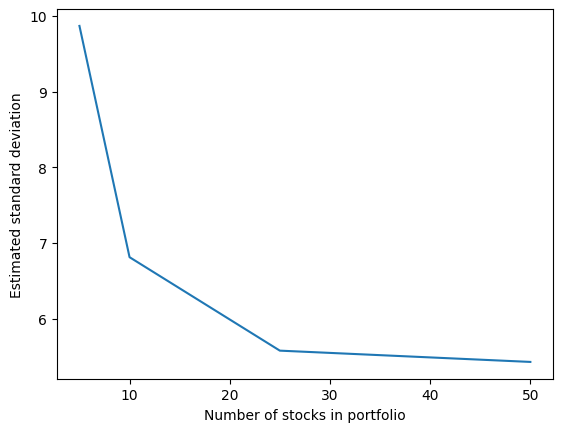

In [ ]:
# 1.a

# calculate values
mv = pd.concat([
    df.iloc[:, :5].mean(axis=1).aggregate(["mean", "std"]),
    df.iloc[:, :10].mean(axis=1).aggregate(["mean", "std"]),
    df.iloc[:, :25].mean(axis=1).aggregate(["mean", "std"]),
    df.iloc[:, :50].mean(axis=1).aggregate(["mean", "std"])
],
               axis=1)
mv.columns = [5, 10, 25, 50]
print(mv)
mv.to_csv(os.path.join(base_dir, "1a_tab.csv"))
mv = mv.T

# plot std
plt.plot(mv["std"])
plt.xlabel("Number of stocks in portfolio")
plt.ylabel("Estimated standard deviation")
plt.savefig(os.path.join(base_dir, "1a_plot.png"))
plt.show()

N                       5          10         25         50
Sample Variance  97.359655  46.400674  31.103919  29.464326
Var Component    45.336639  15.595865   5.072274   2.309179
Cov Component    52.023016  30.804808  26.031644  27.155147


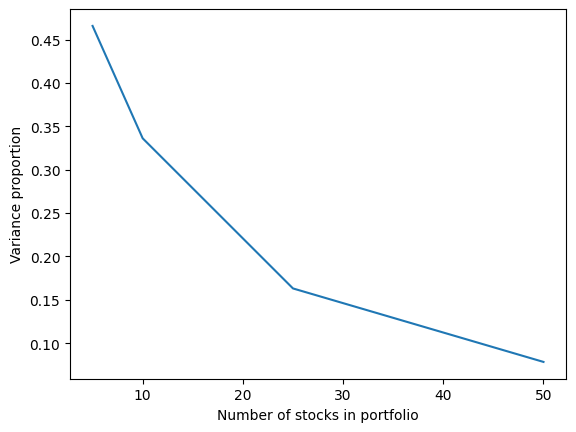

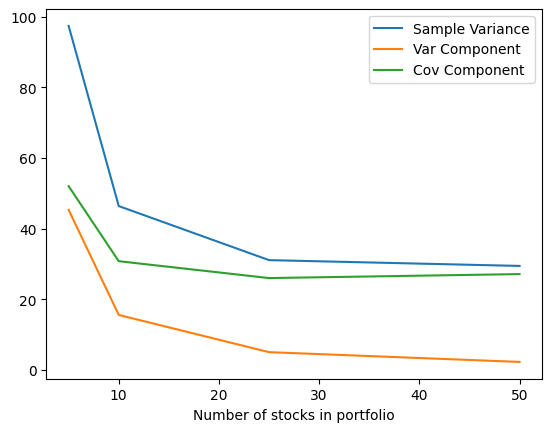

In [ ]:
# 1.b
tv_comp = pd.Series([
    df.iloc[:, :5].mean(axis=1).var(), df.iloc[:, :10].mean(axis=1).var(),
    df.iloc[:, :25].mean(axis=1).var(), df.iloc[:, :50].mean(axis=1).var()
])
v_comp = pd.Series([
    df.var().iloc[:5].mean() / 5.,
    df.var().iloc[:10].mean() / 10.,
    df.var().iloc[:25].mean() / 25.,
    df.var().iloc[:50].mean() / 50.
])
cov_comp = tv_comp - v_comp
v_df = pd.DataFrame({
    "Sample Variance": tv_comp,
    "Var Component": v_comp,
    "Cov Component": cov_comp
})
v_df.index = [5, 10, 25, 50]
v_df.index.name = "N"
v_df = v_df.T
print(v_df)
v_df.to_csv(os.path.join(base_dir, "1b_tab.csv"))
v_df = v_df.T

# plot proportion
v_prop = v_df["Var Component"] / v_df["Sample Variance"]
plt.plot(v_prop)
plt.xlabel("Number of stocks in portfolio")
plt.ylabel("Variance proportion")
plt.savefig(os.path.join(base_dir, "1b_varcomp.png"))
plt.show()

# plot decomp
plt.plot(v_df["Sample Variance"], label="Sample Variance")
plt.plot(v_df["Var Component"], label="Var Component")
plt.plot(v_df["Cov Component"], label="Cov Component")
plt.xlabel("Number of stocks in portfolio")
plt.legend()
plt.savefig(os.path.join(base_dir, "1b_decomp.png"))
plt.show()

In [ ]:
# 1.d
tstat = mv["mean"] / (mv["std"] / np.sqrt(df.shape[0]))
pval = (1. - t.cdf(tstat, df.shape[0] - 1)) * 2.
tstat = pd.DataFrame({"t Stat": tstat, "p-value": pval})
tstat.index = [5, 10, 25, 50]
tstat.index.name = "N"
tstat = tstat.T
print(tstat)
tstat.to_csv(os.path.join(base_dir, "1d_tab.csv"))

N              5         10        25        50
t Stat   2.061891  2.427765  2.915321  2.992416
p-value  0.040663  0.016182  0.004007  0.003159


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# 读取 Excel 文件
file_path = "/content/Problem_Set1.xlsx"  # 如果是本地路径，请替换为你的路径
xls = pd.ExcelFile(file_path)

# 跳过前面多余的行，获取真正的数据
returns_df = xls.parse('stock_return', skiprows=5)

# 设置列名
returns_df.columns = returns_df.iloc[0]
returns_df = returns_df.drop(index=returns_df.index[0])

# 重命名日期列
returns_df = returns_df.rename(columns={returns_df.columns[0]: "Date"})
returns_df['Date'] = pd.to_datetime(returns_df['Date'], errors='coerce')

# 设置索引，并转换收益为数值类型
returns_df = returns_df.set_index("Date")
returns_df = returns_df.apply(pd.to_numeric, errors='coerce')

# 把百分数转为小数
monthly_returns = returns_df / 100

# 随机选股票组合
np.random.seed(42)
tickers = monthly_returns.columns.tolist()
ew_5 = np.random.choice(tickers, size=5, replace=False)
ew_10 = np.random.choice(tickers, size=10, replace=False)
ew_25 = np.random.choice(tickers, size=25, replace=False)
ew_50 = tickers

# 构造组合收益（等权平均）
portfolio_returns = pd.DataFrame({
    'EW_5': monthly_returns[ew_5].mean(axis=1),
    'EW_10': monthly_returns[ew_10].mean(axis=1),
    'EW_25': monthly_returns[ew_25].mean(axis=1),
    'EW_50': monthly_returns[ew_50].mean(axis=1),
})

# 对每个组合做 t 检验
t_stats = {}
p_values = {}
n_obs = {}

for col in portfolio_returns.columns:
    r = portfolio_returns[col].dropna()
    t_stat = r.mean() / (r.std(ddof=1) / np.sqrt(len(r)))
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(r) - 1))
    t_stats[col] = t_stat
    p_values[col] = p_value
    n_obs[col] = len(r)

# 汇总结果
t_test_results = pd.DataFrame({
    't_stat': t_stats,
    'p_value': p_values,
    'n_obs': n_obs
})

# 是否拒绝零假设（平均收益不等于 0）
t_test_results['reject_H0 (5%)'] = t_test_results['p_value'] < 0.05

# 打印结果
print(t_test_results)

         t_stat   p_value  n_obs  reject_H0 (5%)
EW_5   2.483255  0.013944    179            True
EW_10  3.244145  0.001407    179            True
EW_25  3.207101  0.001590    179            True
EW_50  2.923590  0.003910    179            True


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import t

# === 1. 读取数据 ===
file_path = "/content/Problem_Set1.xlsx"   # 如果在本地，请修改路径
df = pd.read_excel(file_path, sheet_name="stock_return", skiprows=5)

# === 2. 设置列名和日期 ===
df.columns = df.iloc[0]              # 第一行作为列名
df = df.drop(index=0)                # 去掉那行
df = df.rename(columns={df.columns[0]: "Date"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.set_index("Date")

# 转换为数值类型（空值保留为 NaN）
df = df.apply(pd.to_numeric, errors="coerce")


# === 4. 构建等权重组合 (5, 10, 25, 50) ===
portfolio_returns = pd.DataFrame({
    "EW_5": df_50.iloc[:, :6].mean(axis=1),
    "EW_10": df_50.iloc[:, :10].mean(axis=1),
    "EW_25": df_50.iloc[:, :25].mean(axis=1),
    "EW_50": df_50.iloc[:, :50].mean(axis=1)
})

# === 5. 计算 t 统计量和 p 值 ===
n_obs = portfolio_returns.shape[0]   # 样本数（月数）

t_stats = portfolio_returns.mean() / (portfolio_returns.std(ddof=1) / np.sqrt(n_obs))
p_values = 2 * (1 - t.cdf(np.abs(t_stats), df=n_obs - 1))

# === 6. 汇总结果 ===
t_test_results = pd.DataFrame({
    "t_stat": t_stats,
    "p_value": p_values,
    "n_obs": n_obs,
    "reject_H0 (5%)": p_values < 0.05
})

print(t_test_results)

# === 7. 保存结果（可选）===
t_test_results.to_csv("1d_results.csv")

NameError: name 'df_50' is not defined

In [ ]:
# 1.e
agg = pd.DataFrame({
    "TXN": df["TXN"],
    "eqw": df.iloc[:, :50].mean(axis=1),
    "Market": df["Market"]
})
aggd = agg.aggregate(["mean", "std", "max", "min", "skew", "kurt"]).T
aggd["range"] = aggd["max"] - aggd["min"]
aggd["stu_range"] = aggd["range"] / aggd["std"]
aggd["jb_pval"] = pd.Series([jarque_bera(agg[c])[1] for c in agg.columns],
                            index=agg.columns)

aggd = aggd.T
print(aggd)
aggd.to_csv(os.path.join(base_dir, "1e_tab.csv"))

result = pd.DataFrame(index=agg.columns)
# JB 检验（返回统计量和 p-value）
jb_test = [jarque_bera(agg[c]) for c in agg.columns]
result["JB_statistic"] = [stat[0] for stat in jb_test]
result["p_value"] = [stat[1] for stat in jb_test]
print(result["JB_statistic"])

aggd['TXN']

                 TXN           eqw     Market
mean        0.655436  1.210693e+00   0.538871
std         9.476511  5.428105e+00   4.493683
max        26.935300  1.815801e+01  11.398200
min       -32.534200 -2.369998e+01 -18.460300
skew       -0.183571 -5.287881e-01  -0.671317
kurt        1.092953  2.496044e+00   1.405790
range      59.469500  4.185799e+01  29.858500
stu_range   6.275463  7.711345e+00   6.644550
jb_pval     0.011413  7.483226e-12   0.000002
TXN        8.945931
eqw       51.236714
Market    26.639639
Name: JB_statistic, dtype: float64


,TXN
mean,0.655436
std,9.476511
max,26.935300
min,-32.534200
skew,-0.183571
kurt,1.092953
range,59.469500
stu_range,6.275463
jb_pval,0.011413


In [ ]:
from scipy.stats import kurtosis, jarque_bera

# 创建三个序列
agg = pd.DataFrame({
    "TXN": df["TXN"],
    "eqw": df.iloc[:, :50].mean(axis=1),
    "Market": df["Market"]
})

result = pd.DataFrame(index=agg.columns)

# Studentized Range
result["stu_range"] = (agg.max() - agg.min()) / agg.std()

# Skewness
result["skewness"] = agg.skew()

# Kurtosis（非excess）
result["kurtosis"] = agg.apply(lambda x: kurtosis(x, fisher=False))

# JB 检验（返回统计量和 p-value）
jb_test = [jarque_bera(agg[c]) for c in agg.columns]
result["JB_statistic"] = [stat[0] for stat in jb_test]
result["p_value"] = [stat[1] for stat in jb_test]

# 输出与保存
print(result)
result.to_csv(os.path.join(base_dir, "1e_tab.csv"))

        stu_range  skewness  kurtosis  JB_statistic       p_value
TXN      6.275463 -0.183571  4.029679      8.945931  1.141342e-02
eqw      7.711345 -0.528788  5.394097     51.236714  7.483226e-12
Market   6.644550 -0.671317  4.333894     26.639639  1.641632e-06


In [ ]:
from scipy.stats import chi2

df0 = pd.read_excel("Problem_Set1.xlsx")
returns = df0.iloc[:, 1:51].apply(pd.to_numeric, errors="coerce").dropna(how="all")

CTL  = returns.iloc[:, 0].dropna()
EW50 = returns.iloc[:, :50].mean(axis=1).dropna()

cand = df0.filter(regex="(?i)market|mkt|index|crsp|vwretd")
if cand.shape[1] >= 1:
    Market = pd.to_numeric(cand.iloc[:, 0], errors="coerce").dropna()
    market_name = "Market"
else:
    Market = EW50.copy()
    market_name = "Market (proxy)"

series = {"CTL": CTL, "50-stocks": EW50, market_name: Market}

def stats_block(x: pd.Series):
    x = x.dropna()
    if x.empty:
        return [np.nan]*8
    T  = len(x)
    mu = x.mean()
    s  = x.std(ddof=1)
    z  = (x - mu) / s
    skew = (z**3).mean()                 # 样本 skewness
    kurt = (z**4).mean()                 # Pearson kurtosis（正态=3）
    mx, mn = x.max(), x.min()
    rng = mx - mn
    stu = rng / s if s != 0 else np.nan
    # Jarque–Bera：用 excess kurtosis = kurt - 3
    jb = T/6 * (skew**2) + T/24 * ((kurt - 3)**2)
    jb_p = 1 - chi2.cdf(jb, df=2)
    return [mx, mn, rng, s, stu, skew, kurt, jb_p]

table = {k: stats_block(v) for k, v in series.items()}
result_1e = pd.DataFrame(
    table,
    index=["Max","Min","Range","Stdev","Stu Range","Skewness","Kurtosis","JB p-value"]
).round(4)

display(result_1e)

,CTL,50-stocks,Market (proxy)
Max,26.9353,25.5000,25.5000
Min,-32.5342,-23.7000,-23.7000
Range,59.4695,49.2000,49.2000
Stdev,9.4502,5.7061,5.7061
Stu Range,6.2929,8.6223,8.6223
Skewness,-0.1816,-0.0892,-0.0892
Kurtosis,4.0075,6.1630,6.1630
JB p-value,0.0132,0.0000,0.0000


In [ ]:
# 1.f
coef_dict = {}
for c in df.columns[:10]:
    mod = smf.ols("%s ~ Market" % c, data=df)
    fit = mod.fit()
    vals = fit.params
    vals["r2"] = fit.rsquared
    mod = smf.ols("%s ~ Market - 1" % c, data=df)
    fit = mod.fit()
    vals["Market no int"] = fit.params["Market"]
    coef_dict[c] = vals
coefs = pd.DataFrame(coef_dict)
coefs.to_csv(os.path.join(base_dir, "1f_beta.csv"))
print(coef_dict)

{'TXN': Intercept       -0.098728
Market           1.399526
r2               0.440423
Market no int    1.396915
dtype: float64, 'ISRG': Intercept        2.511815
Market           1.399259
r2               0.129686
Market no int    1.465702
dtype: float64, 'CIEN': Intercept       -1.425664
Market           2.515438
r2               0.359474
Market no int    2.477726
dtype: float64, 'BHI': Intercept       -0.003740
Market           1.266533
r2               0.320384
Market no int    1.266435
dtype: float64, 'WDC': Intercept        2.198642
Market           1.584036
r2               0.179544
Market no int    1.642195
dtype: float64, 'CAH': Intercept        0.335374
Market           0.648666
r2               0.193944
Market no int    0.657537
dtype: float64, 'CCI': Intercept        0.768952
Market           1.554532
r2               0.265573
Market no int    1.574873
dtype: float64, 'BBT': Intercept        0.199588
Market           0.721062
r2               0.176036
Market no int    0.7263

In [ ]:
with pd.ExcelWriter("HW1.xlsx", engine="openpyxl") as writer:
    result.to_excel(writer, sheet_name="1f", index=False)

IndexError: At least one sheet must be visible

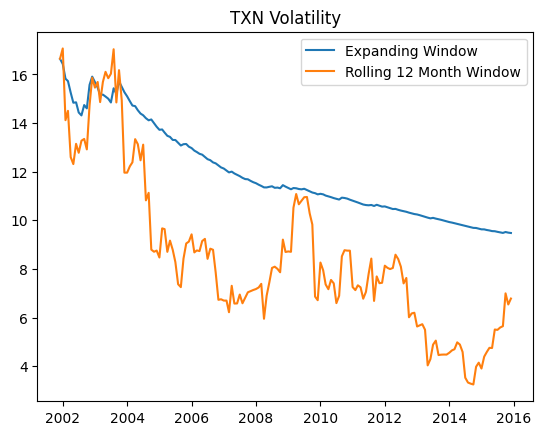

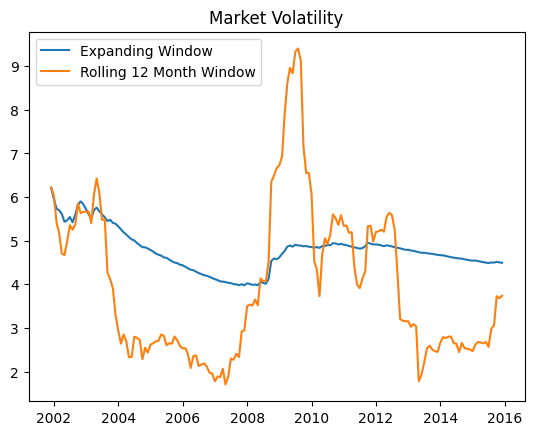

In [ ]:
# 2.a
vol = pd.DataFrame({
    "TXN_exp": df["TXN"].expanding().std(),
    "TXN_12m": df["TXN"].rolling(12).std(),
    "mkt_exp": df["Market"].expanding().std(),
    "mkt_12m": df["Market"].rolling(12).std()
})
vol = vol.dropna()

# plot TXN
plt.plot(vol["TXN_exp"], label="Expanding Window")
plt.plot(vol["TXN_12m"], label="Rolling 12 Month Window")
plt.title("TXN Volatility")
plt.legend()
plt.savefig(os.path.join(base_dir, "2a_TXN.png"))
plt.show()


# plot Market
plt.plot(vol["mkt_exp"], label="Expanding Window")
plt.plot(vol["mkt_12m"], label="Rolling 12 Month Window")
plt.title("Market Volatility")
plt.legend()
plt.savefig(os.path.join(base_dir, "2a_mkt.png"))

plt.show()

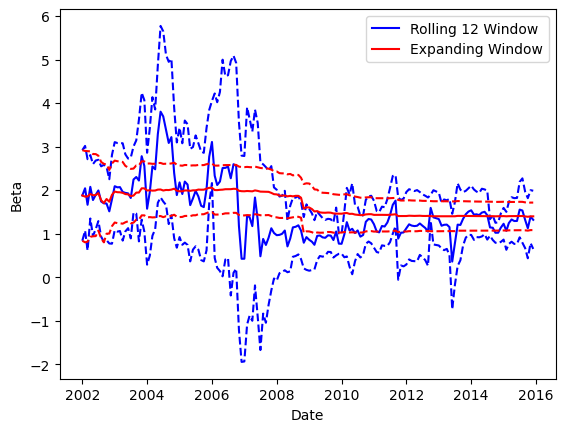

In [ ]:
# 2.b
exp_param_l = []
rll_param_l = []
exp_se_l = []
rll_se_l = []
for t in range(12, df.shape[0]):

    df_texp = df.iloc[:t, :]
    df_trll = df.iloc[t - 12:t, :]

    modexp = smf.ols("TXN ~ Market", data=df_texp)
    fitexp = modexp.fit()
    exp_param_l.append(fitexp.params["Market"])
    exp_se_l.append(fitexp.HC0_se["Market"])

    modrll = smf.ols("TXN ~ Market", data=df_trll)
    fitrll = modrll.fit()
    rll_param_l.append(fitrll.params["Market"])
    rll_se_l.append(fitrll.HC0_se["Market"])

beta_df = pd.DataFrame(
    {
        "beta_exp": exp_param_l,
        "exp_se": exp_se_l,
        "beta_roll": rll_param_l,
        "roll_se": rll_se_l
    },
    index=df.index[12:])
beta_df.index.name = "date"

# plot beta
plt.plot(beta_df["beta_roll"], label="Rolling 12 Window", color="b")
plt.plot(beta_df["beta_exp"], label="Expanding Window", color="r")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.savefig(os.path.join(base_dir, "2b_beta.png"))
plt.clf()

# plot beta + 1SE
plt.plot(beta_df["beta_roll"], label="Rolling 12 Window", color="b")
plt.plot(beta_df["beta_roll"] + 2 * beta_df["roll_se"],
         color="b",
         linestyle="--")
plt.plot(beta_df["beta_roll"] - 2 * beta_df["roll_se"],
         color="b",
         linestyle="--")
plt.plot(beta_df["beta_exp"], label="Expanding Window", color="r")
plt.plot(beta_df["beta_exp"] + 2 * beta_df["exp_se"],
         color="r",
         linestyle="--")
plt.plot(beta_df["beta_exp"] - 2 * beta_df["exp_se"],
         color="r",
         linestyle="--")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.savefig(os.path.join(base_dir, "2b_beta_ci.png"))
plt.show()

NameError: name 'tstat' is not defined

The error `NameError: name 'tstat' is not defined` indicates that the variable `tstat` was used before it was assigned a value. This is because the cell where `tstat` is defined (cell `ab61c0ce`) was not executed in the current runtime.

To fix this, I will execute the cell that defines `tstat` before running the cell that exports the data.

In [ ]:
# Execute the cell that defines tstat
get_ipython().run_cell('ab61c0ce')

NameError: name 'ab61c0ce' is not defined

<ExecutionResult object at 7f009d4ba510, execution_count=None error_before_exec=None error_in_exec=name 'ab61c0ce' is not defined info=<ExecutionInfo object at 7f009d4b99d0, raw_cell="ab61c0ce" store_history=False silent=False shell_futures=True cell_id=None> result=None>